In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

np.dtype(np.float128)

dtype('float128')

In [29]:
def linear_func(x, k):
    return k*x


def straight_func(x, k, b):
    return k*x + b


class func_printer:
    def __init__(self, func, template=[], precision=3):
        self.func = func
        self.template = template
        self.precision = precision

    
    def print(self, *args, **kwargs):
        if "precision" in kwargs.keys():
            prec = kwargs["precision"]
        else:
            prec = self.precision
        form = "{0:0." + str(prec) + "f}"
        result = ""
        i = 0

        for step in self.template:
            if step not in set(range(2)):
                 result += step
                 continue
            
            if step == 0:
                result += str(form.format(args[i]))
                i += 1
                continue

            if step == 1:
                sign = "- " if args[i] < 0 else "+ "
                result += sign + str(form.format(np.abs(args[i])))
                i += 1
                continue
        return result


linear_func_printer = func_printer(
    linear_func,
    ["$y = ", 0, r"\cdot x$"],
    3
)

straight_func_printer = func_printer(
    straight_func,
    ["$y = ", 0, r"\cdot x ", 1, "$"],
    3
)

In [30]:
def plot(x, y, func: func_printer = None, xlim=None, ylim=None, xerror=None, yerror=None, ejects=None, lines=[], xlabel="", ylabel="", figsize=(12, 6), title="",
         dots_legend="", fmt="+r", approx_legend="", name=None, precision_print=3, func_dots_linspace=(None, None, 1000), dropna=False):
    '''
    Строит график и аппроксимирует его функцией

    :param x: массив иксов

    :param y: массив игриков

    :param func: объект, имеющий поля 
        func  -- вызываемая функция для аппроксимации;
        print -- метод, принимающий параметры и возвращающий строку

    :param xlim: параметр xlim для plt.plot

    :param ylim: параметр ylim для plt.plot

    :param xerror: массив погрешностей иксов

    :param yerror: массив погрешностей игриков

    :param ejects: список индексов точек, которые считаем выбросами (их выбрасываем)

    :param lines: list из tuple, где первый элемент либо 
            "v" -- для вертикальной линии
            "h" -- для горизонтальной
            "s" -- для прямой линии с коэффициентами
        Второй элемент -- kwargs для plt.vlines или plt.hlines соответственно
        или (k, b, x_min, x_max, dots, kwargs) для прямой линии

    :param xlabel: название оси x для plt.xlabel

    :param ylabel: название оси y для plt.ylabel

    :param figsize: размер графика для plt.figure

    :param title: название графика для plt.title

    :param dots_legend: Подпись для точек для plt.plot

    :param dots_args: args для plt.plot

    :param approx_legend: подпись для аппроксимации для plt.plot

    :param name: имя под которым сохраним график в формате pdf, если передать None, то не сохраним

    :param precision_print: число знаков после запятой при выводе числе в легенде

    :param func_dots_range: args для np.linspace при построении графика, если какой-то из элементов None, то он пересчитывается автоматический, 
        в формате (None, None, None) -> (min(x), max(x), 1000)

    :param dropna: Проверять и выкидывать NaN и inf из x и y. Если False -- то нет

    return popt -- параметры функции
    return pcov -- ошибка предсказаня из curve_fit
    '''
    popt, pcov = None, None
    if ejects is not None:
        ejects = set(ejects)
    assert len(x) == len(y), "x and y must be the same size"

    if func is not None and ejects is not None:
        x_new, y_new = [], []
        for i in range(len(x)):
            if i not in ejects:
                x_new.append(x[i])
                y_new.append(y[i])
    else:
        x_new, y_new = x, y

    if dropna:
        mask_x = np.isfinite(x_new)
        mask_y = np.isfinite(y_new)

        _x, _y = [], []
        for i in range(len(x_new)):
            if mask_x[i] and mask_y[i]:
                _x.append(x_new[i])
                _y.append(y_new[i])
        x_new, y_new = _x, _y

    if func is not None:
        popt, pcov = curve_fit(func.func, xdata=x_new, ydata=y_new)

        linspace_args = (
            min(x_new) if func_dots_linspace[0] is None else func_dots_linspace[0],
            max(x_new) if func_dots_linspace[1] is None else func_dots_linspace[1],
            1000 if func_dots_linspace[2] is None else func_dots_linspace[2],
        )

        x_model = np.linspace(*linspace_args)
        y_model = func.func(x_model, *popt)

    
    plt.figure(figsize=figsize)

    for line in lines:
        if line[0] == "v":
            plt.vlines(**line[1])
        elif line[0] == "h":
            plt.hlines(**line[1])
        elif line[0] == "s":
            k, b = line[1:3]

            line_dots_args = (
                min(x_new) if line[3] is None else line[3],
                max(x_new) if line[4] is None else line[4],
                1000 if line[5] is None else line[5],
            )

            line_x_model = np.linspace(*line_dots_args)
            line_y_model = k*line_x_model + b
            line_kwargs = line[6]
            plt.plot(line_x_model, line_y_model, **line_kwargs)


    plt.grid(True, linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    dots_kwargs = {
        "label": dots_legend,
        "fmt": fmt,
    }
    if xerror is not None:
        dots_kwargs["xerr"] = xerror
    if yerror is not None:
        dots_kwargs["yerr"] = yerror

    plt.errorbar(x_new, y_new, **dots_kwargs)

    if func is not None:
        leg = approx_legend + " " + func.print(*popt, precision=precision_print)
        plt.plot(x_model, y_model, color="blue", label=leg)
    plt.legend()
    if name is not None:
        plt.savefig(f"plots/{name}.pdf", format="pdf")

    return popt, pcov

In [31]:
data = pd.read_excel("data.xlsx", sheet_name="specter")
data.head()

,N,Ra,Am_Th,Pu,U
0,1,0,0,0,0
1,2,0,0,0,0
2,3,0,0,0,0
3,4,0,0,0,0
4,5,0,0,0,0


In [32]:
# Табличные
energies = {
    "Ra": np.array([4.784, 5.490, 6.002, 7.687]),
}

In [33]:
# погрешность как половина неизвестного разряда
sigma_energies = {
    "Ra": np.array([0.0005, 0.0005, 0.0005, 0.0005]),
}

In [34]:
# Потом посчитаем
delta_energies = {}

In [35]:
# Посчитала прога на компе
delta_peaks = {
    "Ra": np.array([28.4, 28, 28.4, 27.6]),
    "Am_Th": np.array([24.6, 25.8]),
    "Pu": np.array([23.6, 17.2]),
    "U": np.array([66.5, 106.6]),
}

In [36]:
# Пики на глаз, далее считаем более точно
peaks_apprx = {
    "Ra": np.array([1679, 1923, 2100, 2676]),
    "Am_Th": np.array([1650, 1927]),
    "Pu": np.array([1813, 1928]),
    "U": np.array([1442, 1604]),
}

sigma_peaks = {
    "Ra": [],
    "Am_Th": [],
    "Pu": [],
    "U": [],
}

peaks = {
    "Ra": [],
    "Am_Th": [],
    "Pu": [],
    "U": [],
}

for mat in peaks_apprx.keys():
    for i in range(len(peaks_apprx[mat])):
        peak_appr = peaks_apprx[mat][i]
        delta = delta_peaks[mat][i]
        specter = data[mat][int(peak_appr - delta):int(peak_appr + delta)]
        canals = data["N"][int(peak_appr - delta):int(peak_appr + delta)]

        peak = sum(canals * specter) / sum(specter)
        peaks[mat].append(peak)

        N = sum(specter)
        sigma_canal = np.sqrt(
            sum(specter * np.square(canals - peak)) / sum(specter)
        )
        sigma_peaks[mat].append(sigma_canal / np.sqrt(N))
print("peaks")
for key, item in peaks.items():
    print(f"{key}: {', '.join([str('{:.1f}'.format(x)) for x in item])}")
print()
print("sigma peaks")
for key, item in sigma_peaks.items():
    print(f"{key}: {', '.join([str('{:.1f}'.format(x)) for x in item])}")

for key in peaks.keys():
    peaks[key] = np.array(peaks[key])
    sigma_peaks[key] = np.array(sigma_peaks[key])

peaks
Ra: 1677.3, 1921.9, 2098.4, 2674.6
Am_Th: 1647.7, 1926.8
Pu: 1811.7, 1926.8
U: 1435.6, 1621.4

sigma peaks
Ra: 0.2, 0.2, 0.2, 0.2
Am_Th: 0.2, 0.3
Pu: 0.2, 1.0
U: 2.0, 2.2


## Пункт 1

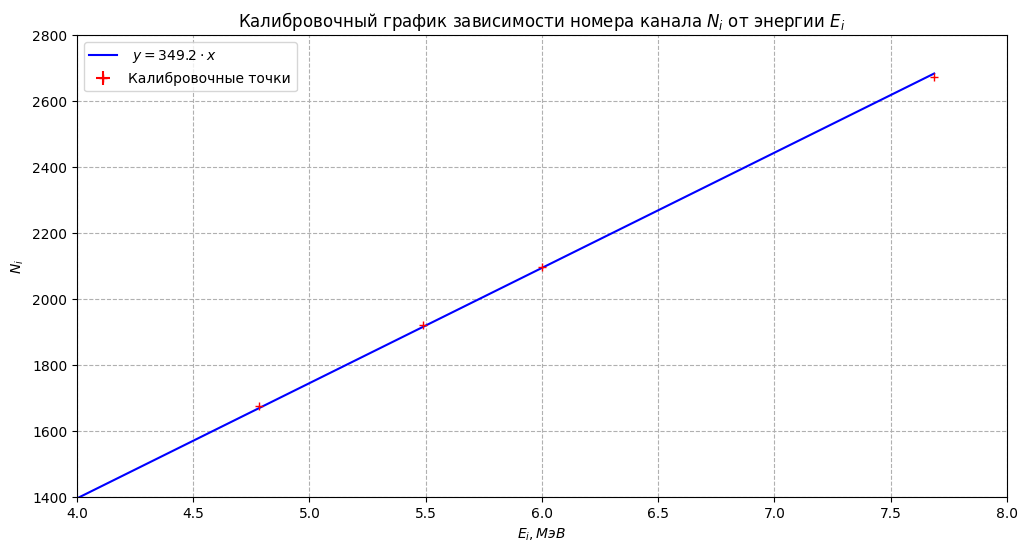

In [37]:
potp, pcov = plot(energies["Ra"], peaks["Ra"], func=linear_func_printer, title=r"Калибровочный график зависимости номера канала $N_i$ от энергии $E_i$", 
                  dots_legend="Калибровочные точки", xlabel=r"$E_i, МэВ$", ylabel=r"$N_i$", name="cal_graph",
                  func_dots_linspace=(0, None, None), xlim=(4, 8), ylim=(1400, 2800), precision_print=1,
                  xerror=sigma_energies["Ra"], yerror=sigma_peaks["Ra"])

alpha = potp[0]
sigma_alpha = np.sqrt(np.diag(pcov))[0]

In [38]:
print(f"alpha = ({alpha:.1f} +- {sigma_alpha:.1f}) МэВ^-1")

alpha = (349.2 +- 0.6) МэВ^-1


In [39]:
# номер канала -> энергия
data["E"] = data["N"] / alpha
data["sigma_E"] = data["E"] * sigma_alpha / alpha

In [40]:
data.describe()

,N,Ra,Am_Th,Pu,U,E,sigma_E
count,4096.00000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,2048.50000,4.511230,1.207520,1.071777,0.193115,5.866362,0.010319
std,1182.55768,17.930305,7.349792,9.798643,0.772267,3.386533,0.005957
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.002864,0.000005
25%,1024.75000,0.000000,0.000000,0.000000,0.000000,2.934613,0.005162
50%,2048.50000,0.000000,0.000000,0.000000,0.000000,5.866362,0.010319
75%,3072.25000,0.000000,0.000000,0.000000,0.000000,8.798112,0.015476
max,4096.00000,144.000000,82.000000,150.000000,8.000000,11.729861,0.020633


$$ E = \cfrac{N}{\alpha}, \ \ \ \sigma_E = \sqrt{ \left( \cfrac{\partial E}{\partial N} \right)^2 \sigma_N^2 + \left( \cfrac{\partial E}{\partial \alpha} \right)^2 \sigma_\alpha^2 } = E \sqrt{\left( \cfrac{\sigma_N}{N} \right)^2 + \left( \cfrac{\sigma_\alpha}{\alpha} \right)^2} $$

In [41]:
sigma_peaks_energy = {
    "Ra": [],
    "Am_Th": [],
    "Pu": [],
    "U": [],
}
peaks_energy = {
    "Ra": [],
    "Am_Th": [],
    "Pu": [],
    "U": [],
}

for key in peaks.keys():
    peaks_energy[key] = peaks[key] / alpha
    sigma_peaks_energy[key] = peaks_energy[key] * np.sqrt(
        np.square(sigma_alpha / alpha) + np.square(sigma_peaks[key] / peaks[key])
    )

print("E peaks:")
for key in peaks.keys():
    print(f"{key}: {', '.join([str('{:.2f}'.format(x)) for x in peaks_energy[key]])}")
print()
print("sigma_E peaks:")
for key in peaks.keys():
    print(f"{key}: {', '.join([str('{:.2f}'.format(x)) for x in sigma_peaks_energy[key]])}")

E peaks:
Ra: 4.80, 5.50, 6.01, 7.66
Am_Th: 4.72, 5.52
Pu: 5.19, 5.52
U: 4.11, 4.64

sigma_E peaks:
Ra: 0.01, 0.01, 0.01, 0.01
Am_Th: 0.01, 0.01
Pu: 0.01, 0.01
U: 0.01, 0.01


## Пункт 2

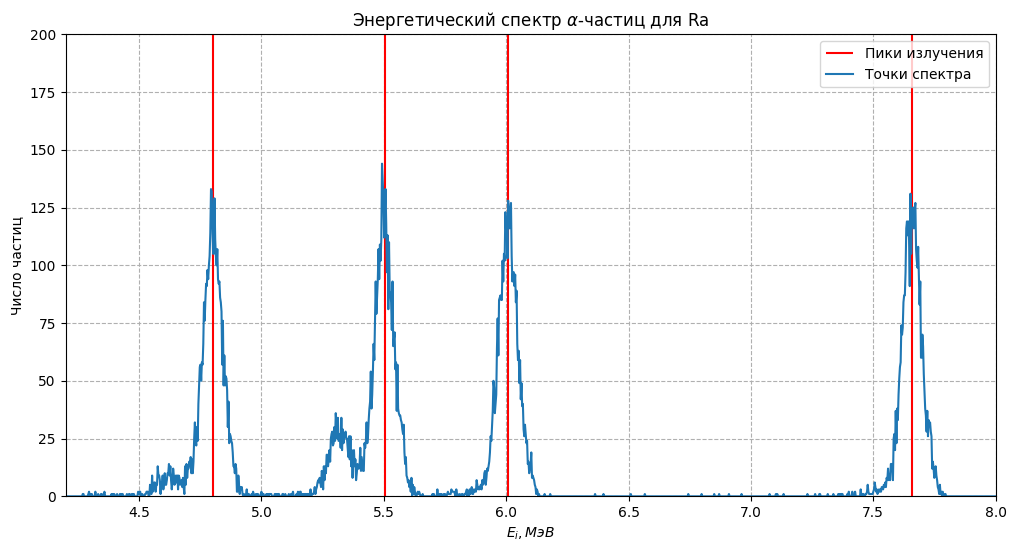

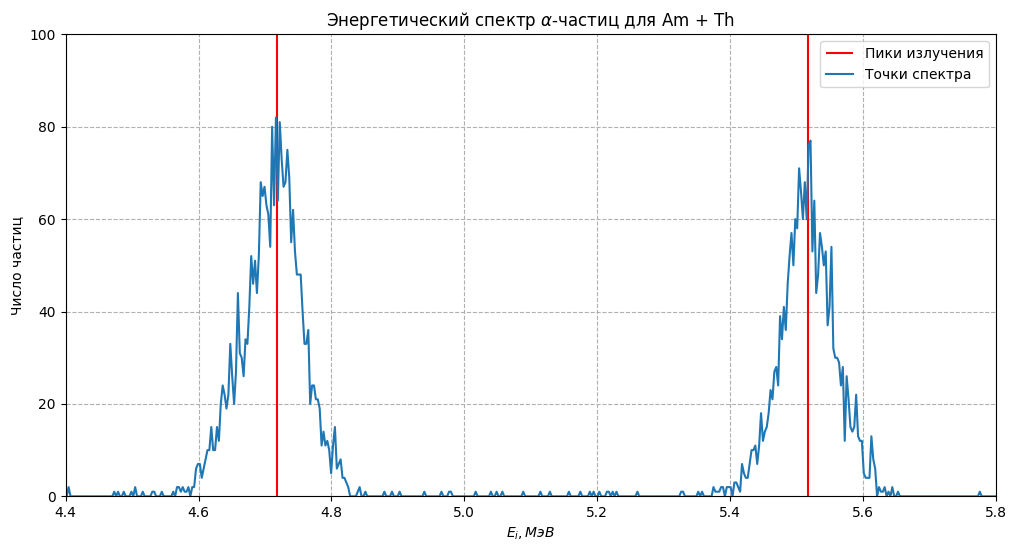

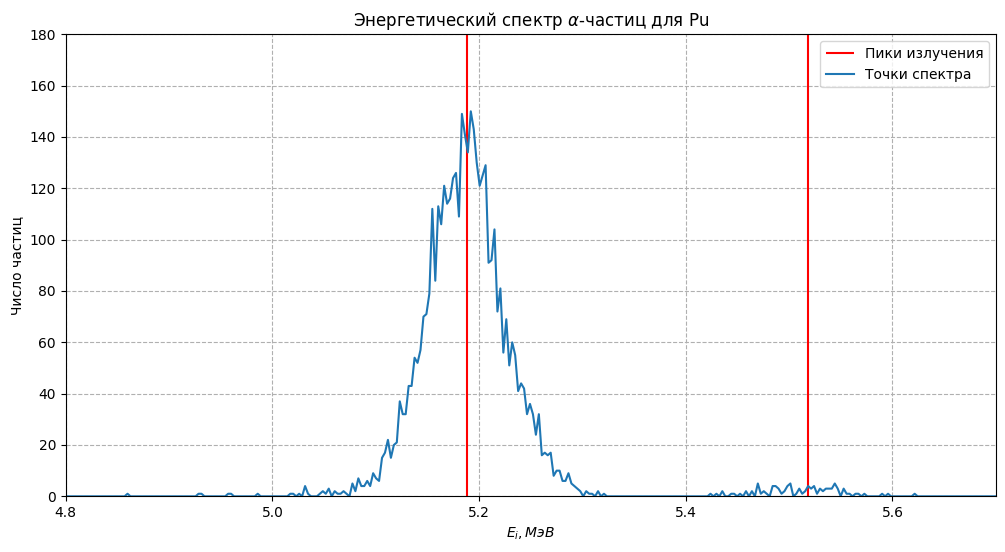

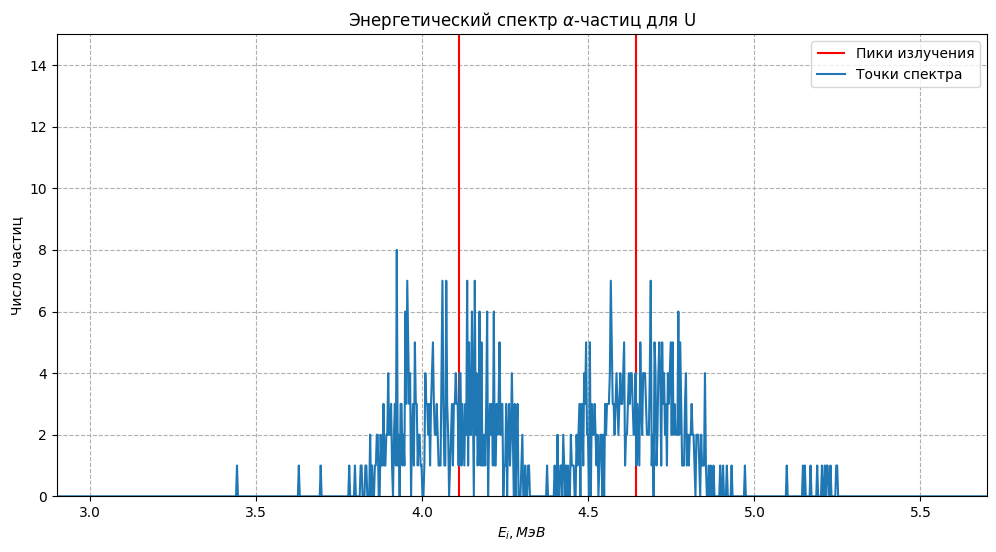

In [42]:
lines_by_keys = {
    "Ra": [("v", {"x": peaks_energy["Ra"], "ymin": 0, "ymax": 200, "colors": "r", "label": "Пики излучения"})],
    "Am_Th": [("v", {"x": peaks_energy["Am_Th"], "ymin": 0, "ymax": 200, "colors": "r", "label": "Пики излучения"})],
    "Pu": [("v", {"x": peaks_energy["Pu"], "ymin": 0, "ymax": 200, "colors": "r", "label": "Пики излучения"})],
    "U": [("v", {"x": peaks_energy["U"], "ymin": 0, "ymax": 200, "colors": "r", "label": "Пики излучения"})],
}
xlims = {
    "Ra": (4.2, 8),
    "Am_Th": (4.4, 5.8),
    "Pu": (4.8, 5.7),
    "U": (2.9, 5.7),
}
ylims = {
    "Ra": (0, 200),
    "Am_Th": (0, 100),
    "Pu": (0, 180),
    "U": (0, 15),
}

print_names = {
    "Ra": "Ra",
    "Am_Th": "Am + Th",
    "Pu": "Pu",
    "U": "U",
}

for mat in ["Ra", "Am_Th", "Pu", "U"]:
    _ = plot(data["E"], data[mat], fmt="", dots_legend="Точки спектра", 
             xlabel="$E_i, МэВ$", ylabel="Число частиц", lines=lines_by_keys[mat], xlim=xlims[mat], ylim=ylims[mat],
             name=f"specter_{mat}", title=rf"Энергетический спектр $\alpha$-частиц для {print_names[mat]}")

In [43]:
for mat in delta_peaks.keys():
    delta_energies[mat] = delta_peaks[mat] / alpha
    print(f"{mat}: {delta_energies[mat]}")

Ra: [0.08133009 0.0801846  0.08133009 0.0790391 ]
Am_Th: [0.0704479  0.07388438]
Pu: [0.06758416 0.04925625]
U: [0.19043842 0.30527422]


In [44]:
R_i = {}
sigma_R_i = {}

for mat in delta_peaks.keys():
    R_i[mat] = delta_energies[mat] / peaks_energy[mat]
    sigma_R_i[mat] = R_i[mat] * np.sqrt(
        np.square(sigma_peaks_energy[mat] / delta_energies[mat]) + np.square(delta_energies[mat] / peaks_energy[mat])
    )
    print(f"R_{mat}: {R_i[mat]}")
    print(f"sigma_{mat}: {sigma_R_i[mat]}")

R_Ra: [0.01693193 0.01456877 0.01353442 0.01031912]
sigma_Ra: [0.00178629 0.00177481 0.00177108 0.00176373]
R_Am_Th: [0.01492969 0.01339018]
sigma_Am_Th: [0.00177903 0.00177324]
R_Pu: [0.01302649 0.00892653]
sigma_Pu: [0.00176971 0.00183427]
R_U: [0.04632119 0.06574518]
sigma_U: [0.00309935 0.00485171]


## Пункт 3

$$ R_{fl} = \cfrac{1}{\sqrt{N}}, \ \ N = \cfrac{E}{E_{mean}} $$

$$ R_{fl} = \sqrt{ \cfrac{E_{mean}}{E} } $$


$$ \sigma_{R_{fl}} = \sqrt{ \left(\cfrac{\partial R_{fl}}{\partial E_{mean}}\right)^2 \sigma^2_{E_{mean}} +  \left(\cfrac{\partial R_{fl}}{\partial E}\right)^2 \sigma^2_{E}} = \sqrt{ \left( \cfrac{1}{2\sqrt{E E_{mean}}} \right)^2 \sigma^2_{E_{mean}} +  \left( \sqrt{E_{mean}} \cdot \cfrac{-1}{2\sqrt{E^3}} \right)^2 \sigma^2_{E}} = $$

$$ = \sqrt{ \cfrac{1}{4E E_{mean}} \sigma^2_{E_{mean}} +  \cfrac{E_{mean}}{4E^3} \sigma^2_{E}} = \cfrac{1}{2} \sqrt{ \cfrac{E_{mean}}{E} } \sqrt{ \cfrac{1}{E_{mean}^2} \sigma^2_{E_{mean}} +  \cfrac{1}{E^2} \sigma^2_{E}} = \cfrac{1}{2} R_{fl} \sqrt{ \cfrac{\sigma^2_{E_{mean}}}{E_{mean}^2}  +  \cfrac{\sigma^2_{E}}{E^2} } $$

In [45]:
E_mean = np.float128('3.6e-6') # МэВ
sigma_E_mean = np.float128('0.05e-6') # МэВ

N_i = {}
R_fl = {}
sigma_R_fl = {}

N_i["Ra"] = peaks_energy["Ra"] / E_mean

R_fl["Ra"] = 1/ np.sqrt(N_i["Ra"])
sigma_R_fl["Ra"] = 0.5 * R_fl["Ra"] * np.sqrt(
    np.square(sigma_E_mean / E_mean) + np.square(sigma_peaks_energy["Ra"] / peaks_energy["Ra"])
)

print("R_fl:", R_fl)
print("sigma_R_fl:", sigma_R_fl)

R_fl: {'Ra': array([0.00086572, 0.00080876, 0.00077401, 0.00068557], dtype=float128)}
sigma_R_fl: {'Ra': array([6.06021174e-06, 5.66137627e-06, 5.41811748e-06, 4.79899487e-06],
      dtype=float128)}


In [46]:
for i in range(4):
    print(f"{R_fl["Ra"][i]:.6f} +- {sigma_R_fl["Ra"][i]:.6f}")

0.000866 +- 0.000006
0.000809 +- 0.000006
0.000774 +- 0.000005
0.000686 +- 0.000005


In [47]:
mean_diff = np.mean(R_i["Ra"] - R_fl["Ra"])
sigma_mean_diff = np.std(R_i["Ra"] - R_fl["Ra"], ddof=1)

print(f"R_i - R_Fl_i = {mean_diff:.3f} +- {sigma_mean_diff:.3f}")

R_i - R_Fl_i = 0.013 +- 0.003


## Пункт 4

In [54]:
# Табличные
T_1_2 = np.array([1620*365*24*60*60,       3.82*24*3600,           3.11*60, np.float128('1.63e-4'), # Ra
                  75400 * 365 * 24 * 3600, 432.2 * 365 * 24 * 3600,                                # Am + Th
                  24110 * 365 * 24 * 3600, np.float128('8e15') * 365 * 24 * 3600,                   # Pu

                  ], dtype=np.float128) # s

sigma_T_1_2 = np.array([np.float128('0.0000005e10'), np.float128('0.0000005e5'), np.float128('0.0005e2'), np.float128('0.005e-4'), # Ra
                        np.float128('0.000000005e12'), np.float128('0.000000005e10'),                                            # Am + Th
                        np.float128('0.000000005e+11'), np.float128('0.000000005e+23')
                        ]) # s
T_1_2

array([5.10883200e+10, 3.30048000e+05, 1.86600000e+02, 1.63000000e-04,
       2.37781440e+12, 1.36298592e+10, 7.60332960e+11, 2.52288000e+23],
      dtype=float128)

In [56]:
Z = np.float128(88)
a_theor = 1.6 * Z
b_theor = -1.6 * np.pow(Z, 2/3) - 21.4
print(f"a_theor = {a_theor:.0f}")
print(f"b_theor = {b_theor:.0f}")

a_theor = 141
b_theor = -53


$$ y = \log{T_{1/2}}, \ \ x = \cfrac{1}{\sqrt{E_\alpha}} $$

Погрешности:

$ \sigma_y = \left| \frac{\partial y}{\partial T_{1/2}} \right| \sigma_{T_{1/2}} = \frac{1}{\ln{10}} \varepsilon_{T_{1/2}} $

$ \sigma_X = \left| \frac{\partial x}{\partial E_\alpha} \right| \sigma_{E_\alpha} = \left(  \frac{1}{2} E_\alpha^{-3/2} \right) \sigma_{E_\alpha} = \frac{x}{2} \varepsilon_{E_\alpha}$

(np.float64(0.45627595278014943), np.longdouble('10.708321621477998938'))
(np.float64(0.4262515012379882), np.longdouble('5.518577105390602021'))
(np.float64(0.4079380937084124), np.longdouble('2.2709116394104811249'))
(np.float64(0.3613269076284363), np.longdouble('-3.7878123955960421925'))
(np.float64(0.4603533880041363), np.longdouble('12.376177952805142046'))
(np.float64(0.42571300592046063), np.longdouble('10.134491369482590522'))
(np.float64(0.4390270538115405), np.longdouble('11.8810038173128216625'))
(np.float64(0.4257069223527365), np.longdouble('23.40189659392731158'))


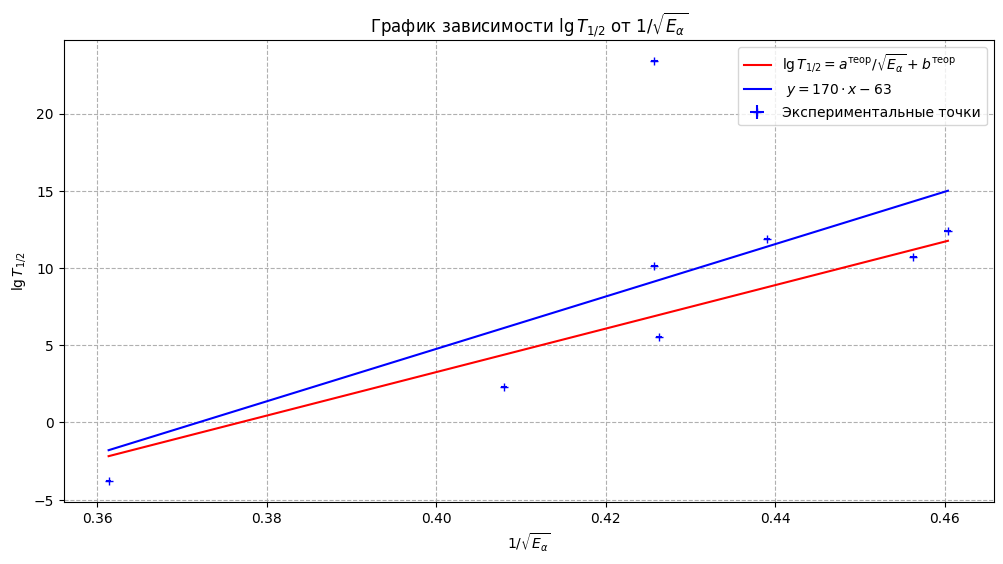

In [57]:
peaks_energy_all = np.concat([peaks_energy[mat] for mat in ["Ra", "Am_Th", "Pu"]])
sigma_peaks_energy_all = np.concat([sigma_peaks_energy[mat] for mat in ["Ra", "Am_Th", "Pu"]])
y = np.log10(T_1_2)
x = 1 / np.sqrt(peaks_energy_all)

print(*list(zip(x, y)), sep="\n")

sigma_y = (sigma_T_1_2 / T_1_2) / np.log(10)
sigma_x = (x / 2) * (sigma_peaks_energy_all / peaks_energy_all)

lines = [
    ("s", a_theor, b_theor, None, None, None, {"color": "red", "label": r"$\lg{T_{1/2}} = a^\text{теор} / \sqrt{E_\alpha} + b^\text{теор}$"})
]



popt, pcov = plot(x, y, straight_func_printer, xerror=sigma_x, yerror=sigma_y,
            xlabel=r"$1 / \sqrt{E_\alpha}$", ylabel=r"$\lg{T_{1/2}}$", name=f"graph_lgT_{mat}", title=r"График зависимости $\lg{T_{1/2}}$ от $1 / \sqrt{E_\alpha}$", 
            dots_legend="Экспериментальные точки", lines=lines, fmt="+b", precision_print=0)

In [51]:
a = popt[0]
sigma_a = np.sqrt(np.diag(pcov))[0]

b = popt[1]
sigma_b = np.sqrt(np.diag(pcov))[1]

print(f"a = ({a:.0f} +- {sigma_a:.0f})")
print(f"b = ({b:.0f} +- {sigma_b:.0f})")

a = (170 +- 80)
b = (-63 +- 34)


$$ \chi^2 = \sum \frac{\left( y - \hat{y} \right)^2}{\sigma_y^2 + \sigma_{\hat{y}}^2} $$

In [52]:
def chi2(y_true, y_pred, sigma):
    return np.sum(
        np.square(y_pred - y_true) / np.square(sigma)
    )

$$\hat{y} = ax + b, \ \ \ \sigma_{\hat{y}} = \sqrt{ \left( \cfrac{\partial \hat{y}}{\partial x} \right)^2 \sigma_x^2 + \left( \cfrac{\partial \hat{y}}{\partial a} \right)^2 \sigma_a^2 + \left( \cfrac{\partial \hat{y}}{\partial b} \right)^2 \sigma_b^2 } = \sqrt{ a^2 \sigma_x^2 + x \sigma_a^2 + \sigma_b^2 } $$

In [53]:
sigma_y_hat = np.sqrt(
    np.square(a * sigma_x) + np.square(x * sigma_a) + np.square(sigma_b)
)

sigma_chi2 = np.sqrt(
    sigma_y_hat**2 + sigma_y**2
)

print(f"chi2 = {chi2(y, a*x + b, sigma_chi2):.3f}")

chi2 = 0.112
